In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Classroom/5th Sem/DEEP LEARNING AI-C-LAB C/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 23008
Unique tags in corpus: 17


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
print(num_words, num_tags)

23009 17


In [ ]:
#retrieving data
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [ ]:
#define mapping between sentences and tags
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
word2idx

{'overshadowed': 1,
 'grudge': 2,
 'Haitian-born': 3,
 'abducting': 4,
 'structures': 5,
 'combat-related': 6,
 'Sitaula': 7,
 'randomly': 8,
 'al-Qadi': 9,
 'Rose': 10,
 'disciplined': 11,
 'stall': 12,
 'tougher': 13,
 'mired': 14,
 'Maldives': 15,
 'Discovery': 16,
 'useful': 17,
 'Denmark': 18,
 '76-year-old': 19,
 'Batad': 20,
 'connections': 21,
 'Dominguez': 22,
 'Persons': 23,
 'Maghreb': 24,
 '5.1-magnitude': 25,
 'vacationing': 26,
 'U.S.-funded': 27,
 'fare': 28,
 'sculptures': 29,
 'accessing': 30,
 'relevant': 31,
 'fresco': 32,
 'backlog': 33,
 'seminary': 34,
 'Abijan': 35,
 'Rehabilitation': 36,
 'Current': 37,
 'Cemetery': 38,
 'execute': 39,
 'vans': 40,
 'Reform': 41,
 'recently': 42,
 'omission': 43,
 'underemployment': 44,
 '3.5': 45,
 'smashing': 46,
 're-sales': 47,
 'ANP': 48,
 'offshore': 49,
 'offense': 50,
 'cater': 51,
 'Wales': 52,
 'tends': 53,
 'lay': 54,
 'Lohan': 55,
 'except': 56,
 'quashed': 57,
 'irrigated': 58,
 'Saleh': 59,
 'Hermann': 60,
 'Muslim

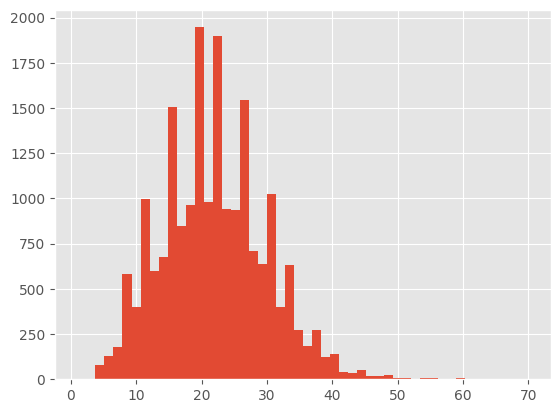

In [ ]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
#adding padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
#splitting data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
#building bidirectional lstm model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1150450   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                             

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
#training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

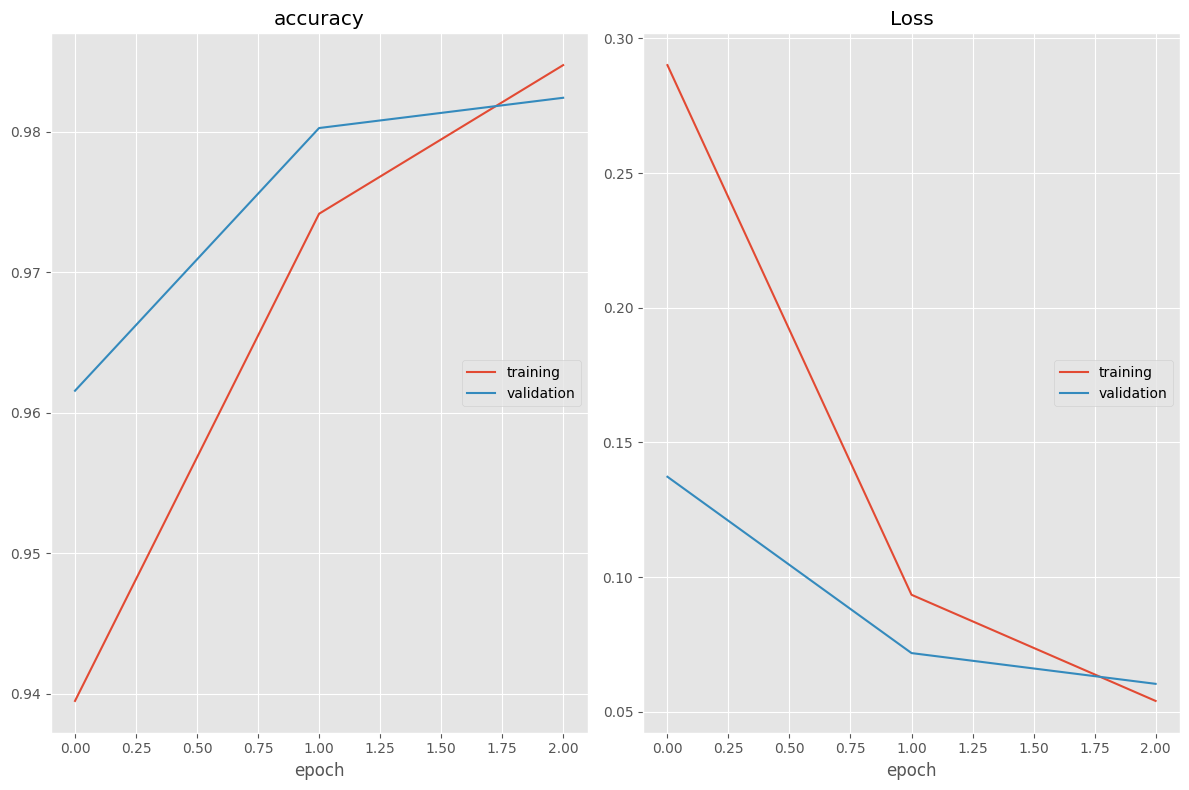

accuracy
	training         	 (min:    0.940, max:    0.985, cur:    0.985)
	validation       	 (min:    0.962, max:    0.982, cur:    0.982)
Loss
	training         	 (min:    0.054, max:    0.290, cur:    0.054)
	validation       	 (min:    0.060, max:    0.137, cur:    0.060)

Epoch 3: val_loss improved from 0.07179 to 0.06037, saving model to model_weights.h5
496/496 [==============================] - 129s 261ms/step - loss: 0.0540 - accuracy: 0.9847 - val_loss: 0.0604 - val_accuracy: 0.9824


In [ ]:
#evalutation
chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

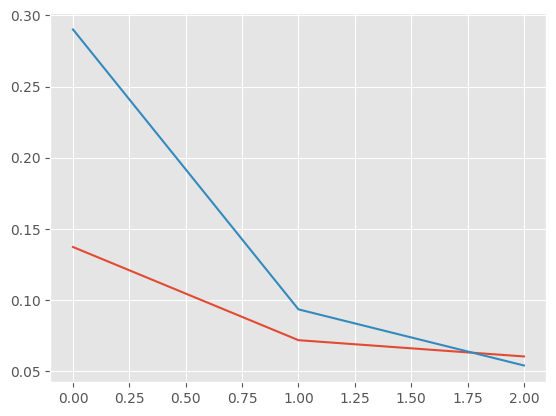

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

In [ ]:
model.evaluate(x_test, y_test)

124/124 [==============================] - 5s 43ms/step - loss: 0.0604 - accuracy: 0.9824


[0.06036793440580368, 0.9824199676513672]

In [ ]:
#testing
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 1s 767ms/step
Word           True 	 Pred

------------------------------
Japan          B-geo	B-geo
says           O	O
it             O	O
wants          O	O
safety         O	O
guarantees     O	O
for            O	O
its            O	O
players        O	O
and            O	O
fans           O	O
when           O	O
its            O	O
national       O	O
soccer         O	O
(              O	O
football       O	O
)              O	O
team           O	O
travels        O	O
to             O	O
North          B-geo	B-geo
Korea          I-geo	I-geo
for            O	O
a              O	O
World          B-org	O
Cup            I-org	O
qualifying     O	O
match          O	O
in             O	O
June           B-tim	B-tim
.              O	O
anemic         O	O
anemic         O	O
anemic         O	O
anemic         O	O
anemic         O	O
anemic         O	O
anemic         O	O
anemic         O	O
anemic         O	O
anemic         O	O
anemic         O	O
anemic         O	O
anemic      